---
title: Converting NetCDF3 to COG (RASI)
author: Julia Signell
date: 'September 26, 2025'
execute:
  cache: true
  freeze: true
---

## Approach

[Cloud-optimized GeoTIFF (COG)](https://www.cogeo.org/) is a geospatial raster (image) data format optimized for on-the-fly analytics and visualization of raster data in cloud applications.

Converting [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) (climate data) to COG can be relevant when the data should be included in GIS or web map applications.

This tutorial shows how this conversion can be done using [Xarray](https://github.com/pydata/xarray) and [rioxarray](https://github.com/corteva/rioxarray), in-memory, avoiding temporary files on-disk.

1. Step-by-step guide to conversion from NetCDF to Cloud-Optimized GeoTIFF
2. Combined workflow including upload to S3

### Step 0 - Installs

In [1]:
import os
import pandas as pd
import rioxarray  # noqa
import s3fs
import xarray as xr

### Step 1 - Inspect source NetCDF

We'll just work with one to start to make sure that it works as expected

In [2]:
SOURCE_URI = "s3://nasa-waterinsight/test/CASI/LSM/HISTORICAL2/PERCENTILES/TotalPrecip_percentiles_201403.nc"

In [3]:
fs = s3fs.S3FileSystem()
fileobj = fs.open(SOURCE_URI)
ds = xr.open_dataset(fileobj, engine="scipy")
ds

<xarray.Dataset> Size: 402kB
Dimensions:                  (ncl0: 1, percentile: 5, lat: 152, lon: 132)
Coordinates:
  * percentile               (percentile) int32 20B 10 25 50 75 90
  * lat                      (lat) float32 608B 23.95 24.05 ... 38.95 39.05
  * lon                      (lon) float32 528B -109.5 -109.5 ... -96.55 -96.45
Dimensions without coordinates: ncl0
Data variables:
    date                     (ncl0) int32 4B ...
    TotalPrecip_Percentiles  (percentile, lat, lon) float32 401kB ...

### Step 2 - Select data variable

The NetCDF only contains a single variable. But that array has 5 different percentiles in it. 

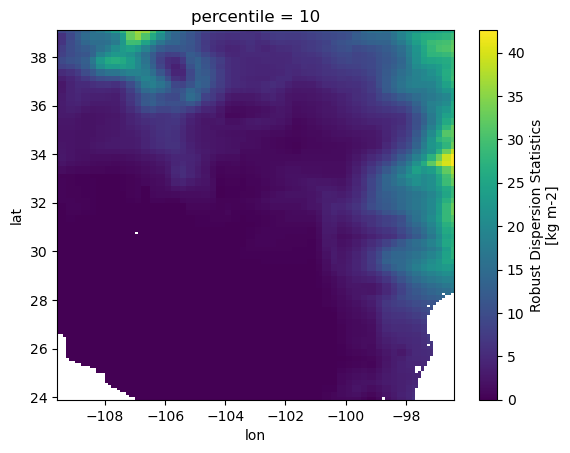

In [6]:
da = ds["TotalPrecip_Percentiles"]
da.sel(percentile=10).plot()

In [7]:
first_value = da.sel(percentile=10).isel(lon=0, lat=0).item()
last_value = da.sel(percentile=10).isel(lon=0, lat=151).item()

print(f"First value in the array is {first_value}, last value along the lat dimension is {last_value}")

First value in the array is nan, last value along the lat dimension is 8.853020668029785


### Step 3. Conform to raster data conventions

Common practice in NetCDF lat/lon data the first grid cell is the south-west corner, i.e. latitude and longitude axes increase along the array dimensions. We can check that that is the case for this dataset by getting the first and last values along the lat dimension of the array and compare those with the plot above.

In [8]:
first_value = da.sel(percentile=10).isel(lon=0, lat=0).item()
last_value = da.sel(percentile=10).isel(lon=0, lat=151).item()

print(f"First value in the array is {first_value}, last value along the lat dimension is {last_value}")

First value in the array is nan, last value along the lat dimension is 8.853020668029785


Common practice in raster formats like GeoTIFF is that the y-axis (latitude in this case) decreases from origin, i.e. the first pixel is the north-west corner.

We can reverse the latitude dimension like this:

In [9]:
da = da.isel(lat=slice(None, None, -1))

The array will look the same when plotted. 

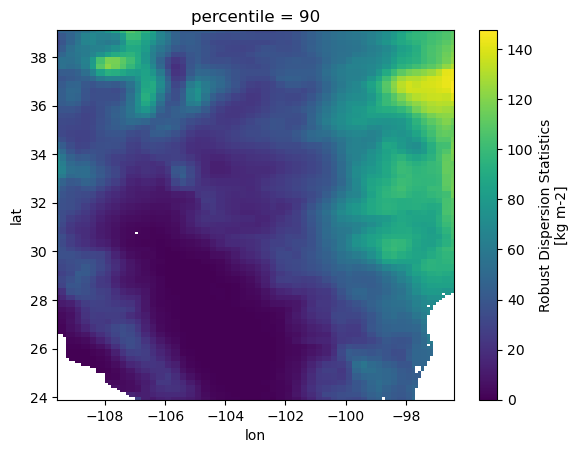

In [10]:
da.sel(percentile=90).plot()

But we can double check that the order of the array is flipped.

In [11]:
first_value = da.sel(percentile=10).isel(lon=0, lat=0).item()
last_value = da.sel(percentile=10).isel(lon=0, lat=151).item()

print(f"First value in the array is {first_value}, last value along the lat dimension is {last_value}")

First value in the array is 8.853020668029785, last value along the lat dimension is nan


Now we need to set raster data attributes which are missing from the NetCDF, to help rio-xarray infer the raster information

In [12]:
da.rio.set_spatial_dims("lon", "lat", inplace=True)
da.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'TotalPrecip_Percentiles' (percentile: 5, lat: 152, lon: 132)> Size: 401kB
[100320 values with dtype=float32]
Coordinates:
  * percentile   (percentile) int32 20B 10 25 50 75 90
  * lat          (lat) float32 608B 39.05 38.95 38.85 ... 24.15 24.05 23.95
  * lon          (lon) float32 528B -109.5 -109.5 -109.3 ... -96.55 -96.45
    spatial_ref  int64 8B 0
Attributes:
    long_name:  Robust Dispersion Statistics
    units:      kg m-2

In [13]:
da.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

Check [affine image transform](https://www.perrygeo.com/python-affine-transforms.html):

    a = width of a pixel
    b = row rotation (typically zero)
    c = x-coordinate of the upper-left corner of the upper-left pixel
    d = column rotation (typically zero)
    e = height of a pixel (typically negative)
    f = y-coordinate of the of the upper-left corner of the upper-left pixel


In [14]:
da.rio.transform()

Affine(0.09999981363311068, 0.0, -109.5999876997853,
       0.0, -0.09999998989484168, 39.09999923200797)

### Step 4 - Write to COG and validate in-memory

GeoTIFFs / COGs can be tuned for performance. Here are some defaults we found to work well (check out [this blog post](https://kokoalberti.com/articles/geotiff-compression-optimization-guide) for detail).

In [15]:
COG_PROFILE = {"driver": "COG", "compress": "DEFLATE", "predictor": 2}

In [16]:
da.rio.to_raster(raster_path="demo.tif", **COG_PROFILE)

## Combined workflow

Run through a range of dates and create a COG for each month for each percentile.

In [17]:
s3_path =  "s3://nasa-waterinsight/test/CASI/LSM/HISTORICAL2/PERCENTILES/"
varname = "TotalPrecip"
COG_PROFILE = {"driver": "COG", "compress": "DEFLATE", "predictor": 2}

dates = pd.date_range("2014-01-01", "2014-03-01", freq="MS")

# make sure the dir exists
os.makedirs("COGS", exist_ok=True)

for date in dates:
    datestr = date.strftime("%Y%m")
    perc_file = f"{s3_path}{varname}_percentiles_{datestr}.nc"
    fileobj = fs.open(perc_file)
    ds = xr.open_dataset(fileobj, engine="scipy")
    da = ds[f"{varname}_Percentiles"]
    da = da.isel(lat=slice(None, None, -1))
    da['time'] = date
    da.lon.attrs["axis"] = "X"
    da.lon.attrs["long_name"] = "longitude"
    da.lon.attrs["units"] = "degrees_east"
    da.lat.attrs["axis"] = "Y"
    da.lat.attrs["long_name"] = "latitude"
    da.lat.attrs["units"] = "degrees_north"
    da.attrs["long name"] = "Average Monthly Precipitation Percentiles"
    da.attrs["units"] = "kg m-2"
    da.rio.set_spatial_dims("lon", "lat", inplace=True)
    da.rio.write_crs("epsg:4326", inplace=True)
    for percentile in da.percentile.values:
        da.sel(percentile=percentile).rio.to_raster(
            raster_path=f"./COGS/{varname}_Percentile_{percentile}_{datestr}_v2.tif",
            **COG_PROFILE
        )